### Lets run the face recognition model we just trained
1. We start by importing the necessary Python libraries. 
  - To import the libraries, click on the cell below (You can tell if the cell is slected if you see a Green outline surrounding the cell), and 
  - Hit Shift + Enter on your keyboard or Click on the Run button from the Dashboard above 


In [1]:
# Import necessary Python libraries 
# OpenCV library
import cv2
# Python Imaging Library useed to load images from files, and to create new images
import PIL.Image
# BytesIO implements read and write bytes data in memory
from io import BytesIO
# Library to display stuff and clear stuff on Jupyer Notebook 
import IPython.display
from IPython.display import clear_output
# Library that makes calls to openCV a bit more convinient 
import imutils
# Useful library for array manipulation 
import numpy as np
# Time library for delay 
import time
# import face recognition library
import face_recognition
# Pickle is used for serializing and de-serializing Python object structures
import pickle

In [2]:
# Set ev3flag to 0
f = open("ev3flag.txt", "w")
f.write("0")
f.close()

# Declare global variable 
flag=0
count=0

2. Lets load the pickle file and the haarcascade files that are used for face recognition

In [3]:
data = pickle.loads(open("/home/pi/Desktop/me35Notebook/opencv/faceDetection/encodings.pickle", "rb").read())
detector = cv2.CascadeClassifier("/home/pi/Desktop/me35Notebook/opencv/faceDetection/haarcascade_frontalface_default.xml")

3. Lets define some functions

In [4]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def array_to_image(a, fmt='jpeg'):
    #Create binary stream object
    f = BytesIO()
    #Convert array to binary stream object
    PIL.Image.fromarray(a).save(f, fmt)
    return IPython.display.Image(data=f.getvalue())

def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()
    # Flip image for natural viewing
    #frame = cv2.flip(frame, 1)
    # Rotate frame
    angle=180
    frame = imutils.rotate(frame, angle)
    return frame

4. Lets start capturing the frame and set aside some space to display our streaming

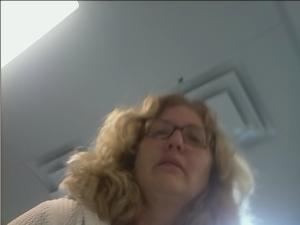

In [5]:
cam = cv2.VideoCapture(0)
d1 = IPython.display.display("Your streaming will be displayed here", display_id=1)

5. Lets run the main loop

In [6]:
#Press 'i' two times to interrupt the Kernel 
#Run the code in the cell below (cam.release) to make sure the Camera is free
while True:
    global flag
    
    if flag==1:
        count+=1
        if count>5:
            count=0
            # Check flag on startup, reset it to 0 
            f = open("ev3flag.txt", "w")
            f.write("0")
            f.close()
    
    t1 = time.time()

    # grab the frame from the threaded video stream and resize it
    # to 300px (to speedup processing)
    frame = get_frame(cam)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # For Pi Zero use inter=cv2.INTER_LINEAR    
    frame = imutils.resize(frame, width=300, inter=cv2.INTER_LINEAR)

    # convert the input frame from (1) BGR to grayscale (for face
    # detection) and (2) from BGR to RGB (for face recognition)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale frame
    rects = detector.detectMultiScale(gray, scaleFactor=1.1, 
        minNeighbors=5, minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE)

    # OpenCV returns bounding box coordinates in (x, y, w, h) order
    # but we need them in (top, right, bottom, left) order, so we
    # need to do a bit of reordering
    boxes = [(y, x + w, y + h, x) for (x, y, w, h) in rects]

    # compute the facial embeddings for each face bounding box
    encodings = face_recognition.face_encodings(frame, boxes)
    names = []

    # loop over the facial embeddings
    for encoding in encodings:
        # attempt to match each face in the input image to our known
        # encodings
        matches = face_recognition.compare_faces(data["encodings"],
            encoding)
        name = "Stranger"

        # check to see if we have found a match
        if True in matches:
            # find the indexes of all matched faces then initialize a
            # dictionary to count the total number of times each face
            # was matched
            matchedIdxs = [i for (i, b) in enumerate(matches) if b]
            counts = {}

            # loop over the matched indexes and maintain a count for
            # each recognized face face
            for i in matchedIdxs:
                name = data["names"][i]
                counts[name] = counts.get(name, 0) + 1

            # determine the recognized face with the largest number
            # of votes (note: in the event of an unlikely tie Python
            # will select first entry in the dictionary)
            name = max(counts, key=counts.get)
            
            flag=1
            # Set flag high
            f = open("ev3flag.txt", "w")
            f.write("1")
            f.close()
            # Update name 
            f = open("name.txt", "w")
            f.write(name)
            f.close()

        # update the list of names
        names.append(name)

    # loop over the recognized faces
    for ((top, right, bottom, left), name) in zip(boxes, names):
        # draw the predicted face name on the image
        cv2.rectangle(frame, (left, top), (right, bottom),
            (0, 255, 0), 2)
        y = top - 15 if top - 15 > 15 else top + 15
        cv2.putText(frame, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
            0.75, (0, 255, 0), 2)

    im = array_to_image(frame)
    d1.update(im)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break


KeyboardInterrupt: 

### 6. Note: Don't run this right away. Scroll above to see the live stream and the button. 
  - Be sure to release the camera resource and stop the main_loop thread

In [7]:
# Note: Only run this if you are done otherwise scroll up to watch the live streaming
# Release the camera resource
cam.release()
IPython.display.clear_output()
print ("Streaming stopped")

Streaming stopped


11. Yay! You've made it to the end of this tutorial. 
  - Please click on Kernel>Restart and Clear Output and Click on "Restart and Clear All Outputs" so that the next person going throught the tutorial can start fresh. Thanks.